## Importing libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ARIMA,auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from matplotlib.pyplot import vlines

import warnings
warnings.filterwarnings('ignore')

## Loading the data

In [36]:
data = pd.read_csv('Final_Data.csv')

In [ ]:
data.head(3)

In [37]:
# Grouping the 'Quantity' column by 'Date' in the 'data' DataFrame and aggregating the sum of the grouped values
df = data.groupby('Date')['Quantity'].sum().reset_index()

In [38]:
# Renaming the "Quantity" column to "Demand"
df.rename(columns = {'Quantity':'Demand'}, inplace = True)

In [39]:
# Extracting the year from the "Date" column
df['year'] = pd.DatetimeIndex(df['Date']).year
#df

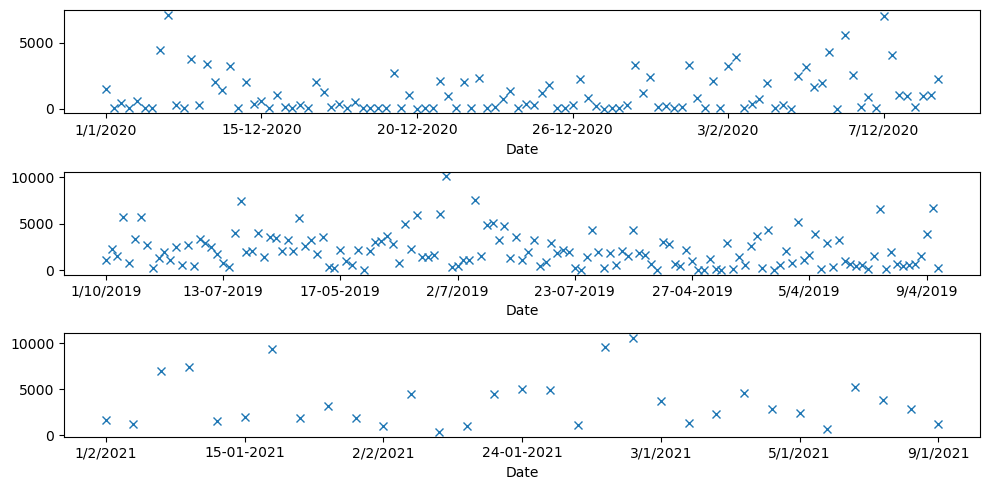

In [40]:
# Ploting time series data grouped by year
years= df.year.unique()
number_years= len(years)
fig, axes = plt.subplots(number_years, 1, figsize=(10,5))
for i, year in enumerate(years):
    (df.set_index('Date')
       .loc[lambda df: df.year == year]
       .plot(y='Demand', ax=axes[i],marker='x',linestyle=""))    
    axes[i].legend_.remove()
fig.set_tight_layout("tight")

In [41]:
# Dropping the column beacuse it will not be required further
df.drop(['year'], axis=1,inplace=True)

In [42]:
df.dtypes

Date       object
Demand    float64
dtype: object

In [43]:
# Converting the datatype of "Date" column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [44]:
df.dtypes

Date      datetime64[ns]
Demand           float64
dtype: object

In [45]:
df['Date'].min()

Timestamp('2019-01-04 00:00:00')

In [46]:
df['Date'].max()

Timestamp('2021-12-01 00:00:00')

**Data is from 4th January 2019 to 1st December 2021**

In [47]:
# Sorting the values of the df dataframe by date in ascending order
df.sort_values("Date", inplace = True)

In [48]:
# Setting the "Date" column as the index of the "df" DataFrame
df.set_index('Date', inplace=True) 

In [49]:
# Creating a new time series dataframe that has monthly aggregated mean of demand
df1 = df['Demand'].resample('M').mean()

In [50]:
# Interpolation is a technique used to estimate
# unknown data points between two known data points.
df1=df1.interpolate(limit_direction="both")
#df1.head()

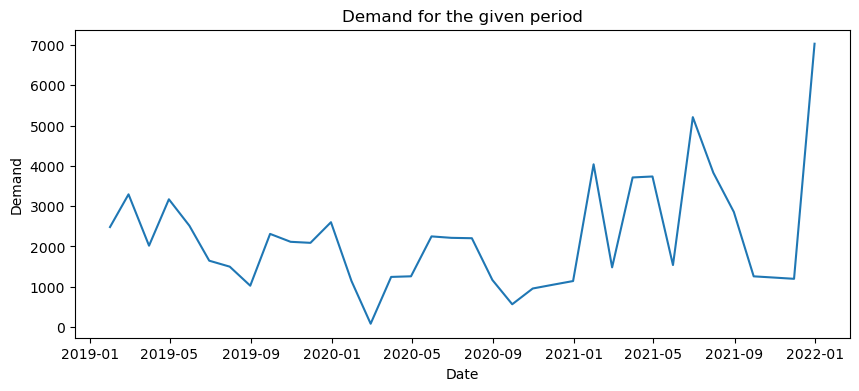

In [51]:
# Creating a line plot of the "Demand" data for the given period
plt.figure(figsize=(10,4))
plt.title('Demand for the given period')
sns.lineplot(data = df1)
plt.show()

**Demand is very low for starting of year 2020 and highest for ending of year 2021**

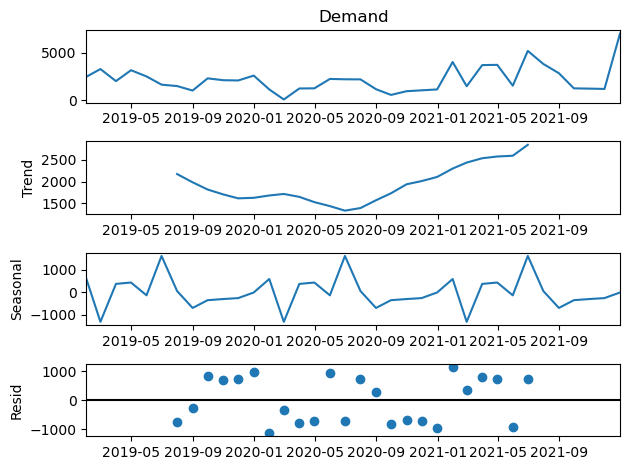

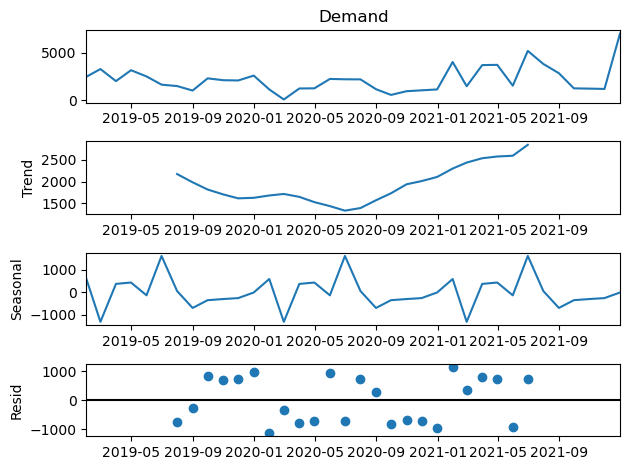

In [52]:
# Performing a time series decomposition
Decomposed_Series = seasonal_decompose(df1,model='additive')
Decomposed_Series.plot()

### Split in test and train in exactly 70 and 30% 

In [53]:
def split(df):
    size=int(len(df)*0.7)
    Train = df.iloc[:size]  # 70 %
    Test = df.iloc[size:] # 30 %
    return Train,Test

In [54]:
Train,Test = split(df1)

In [55]:
Train.shape

(25,)

In [56]:
Test.shape

(11,)

### Function for plotting and validating

In [57]:
def PlotValidation(model,df):
    Forecast = model.forecast(11).rename('Forecast') # Model Forecasting
    # Act, Forecast combining
    Actual_Forecast_Df = pd.concat([df, Forecast], axis = 1) 
    # Plot
    plt.figure(figsize=(10,4))
    sns.lineplot(data = Actual_Forecast_Df)
    plt.show()
    ## Validation
    Validation_Df = Actual_Forecast_Df[-11:].copy()
    print("MAPE",np.mean(abs(Validation_Df['Demand'] - Validation_Df['Forecast'])/Validation_Df['Demand'])*100) # MAPE
    print("RMSE",np.sqrt(np.mean((Validation_Df['Demand'] - Validation_Df['Forecast'])**2))) #RMSE

### Simple Exponential Smoothing (SES)

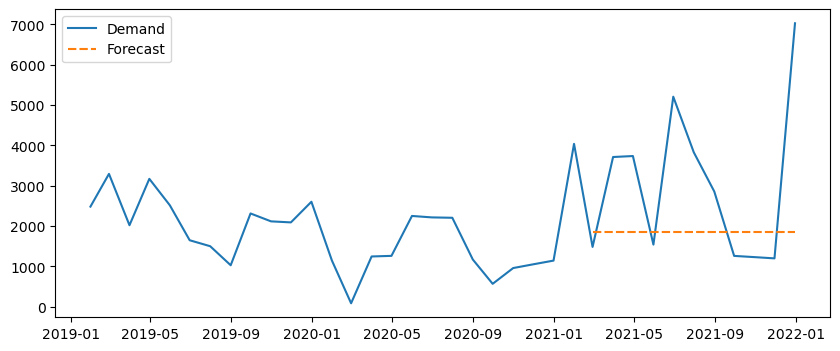

MAPE 47.41663379999169
RMSE 2165.9584226630213


In [58]:
SES = SimpleExpSmoothing(Train).fit()
PlotValidation(SES,df1)

### Double Exponential Smoothing (DES)

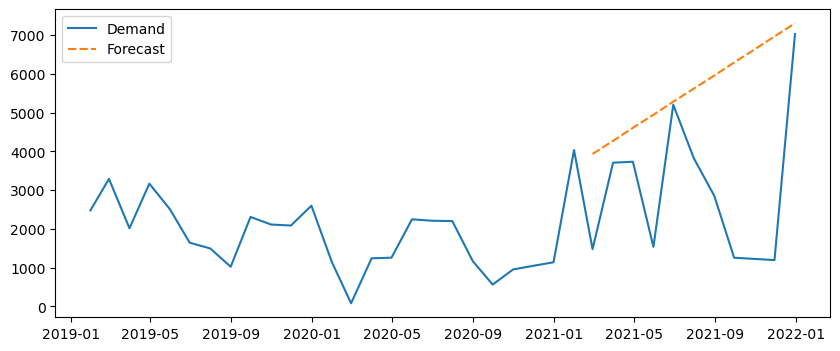

MAPE 173.68287692604721
RMSE 3298.3178547733096


In [59]:
DES = Holt(Train).fit()
PlotValidation(DES,df1)

In [ ]:
# Finding best parameters for DES

myAlpha = np.round(np.arange(0,1.1,0.1),2)
myBeta = np.round(np.arange(0,1.1,0.1),2)

alphaList = []
betaList = []
mapeList = []

for alpha in myAlpha:
    for beta in myBeta:
        #print(alpha, beta)
        DES = Holt(Train).fit(smoothing_level = alpha,smoothing_slope = beta)
        Forecast = DES.forecast(11).rename('Forecast')
        Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)
        Validation_Df = Actual_Forecast_Df[-11:].copy()
        tempMAPE = np.mean(abs(Validation_Df['Demand'] - Validation_Df['Forecast'])/Validation_Df['Demand'])*100 # MAPE
            
            
        alphaList.append(alpha)
        betaList.append(beta)
        mapeList.append(tempMAPE)
            
            
evaluationDf = pd.DataFrame({"alpha": alphaList,
                             "beta": betaList,
                             "MAPE": mapeList})        
            
evaluationDf.to_csv("DES.csv")

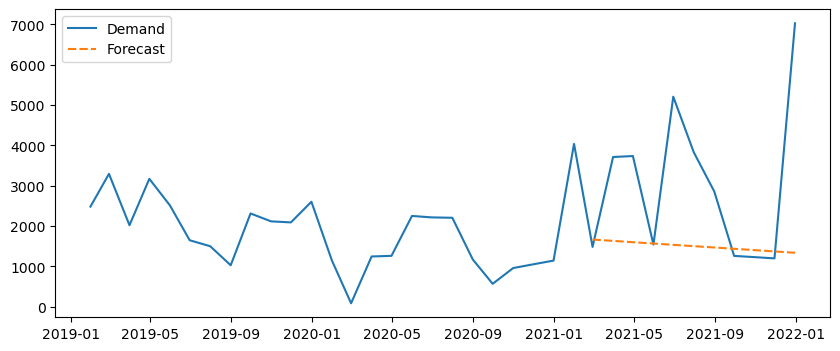

MAPE 39.17303837896338
RMSE 2379.461525150599


In [60]:
DES = Holt(Train).fit(smoothing_level = 0.2,smoothing_slope = 0)
PlotValidation(DES,df1)

### Triple Exponential Smoothing (TES)

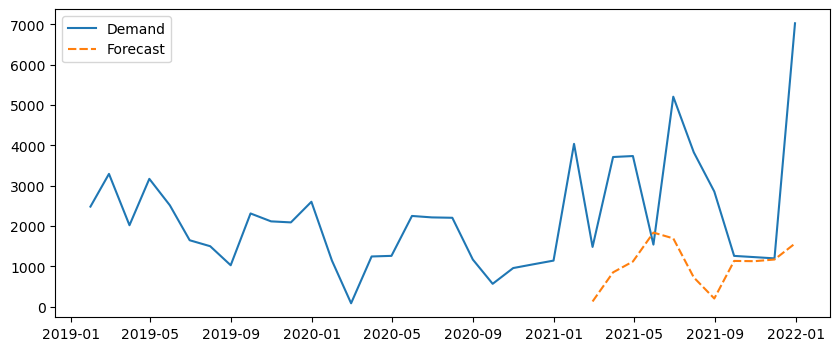

MAPE 54.3286121968984
RMSE 2625.940041845812


In [61]:
TES = ExponentialSmoothing(Train,seasonal='add',trend = 'add').fit()
PlotValidation(TES,df1)

In [ ]:
# # Finding best parameters for TES 

myAlpha = np.round(np.arange(0,1.1,0.1),2)
myBeta = np.round(np.arange(0,1.1,0.1),2)
myGamma = np.round(np.arange(0,1.1,0.1),2)

alphaList = []
betaList = []
gammaList = []
mapeList = []

for alpha in myAlpha:
    for beta in myBeta:
        for gamma in myGamma:
            
            #print(alpha, beta, gamma)
                                              
            TES = ExponentialSmoothing(Train, 
                           seasonal='add', # seasonal='add'
                           trend = 'add').fit(smoothing_level = alpha, 
                                      smoothing_slope = beta, 
                                      smoothing_seasonal = gamma)
            
            Forecast = TES.forecast(11).rename('Forecast')
            Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)
            Validation_Df = Actual_Forecast_Df[-11:].copy()
            tempMAPE = np.mean(abs(Validation_Df['Demand'] - Validation_Df['Forecast'])/Validation_Df['Demand'])*100 # MAPE
            
            
            alphaList.append(alpha)
            betaList.append(beta)
            gammaList.append(gamma)
            mapeList.append(tempMAPE)
            
            
evaluationDf = pd.DataFrame({"alpha": alphaList,
                             "beta": betaList,
                             "gamma": gammaList,
                             "MAPE": mapeList})        
            
evaluationDf.to_csv("dTES.csv")

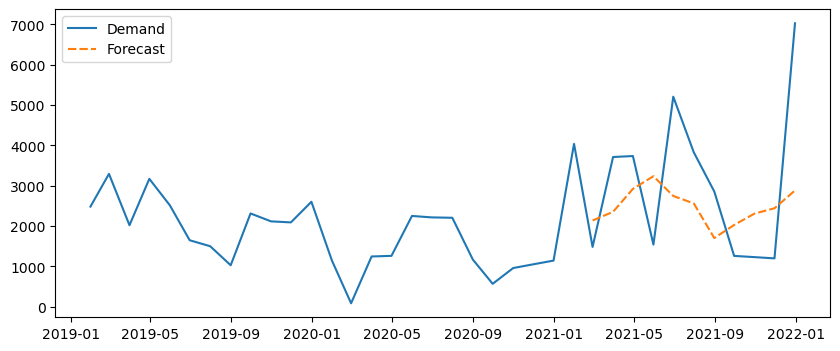

MAPE 58.70316201350961
RMSE 1792.0316842848786


In [62]:
TES = ExponentialSmoothing(Train,seasonal='add',trend='add').fit(smoothing_level=0.45,smoothing_slope=0.05,smoothing_seasonal=0.3)
PlotValidation(TES,df1)

MAPE 94.93509499319977


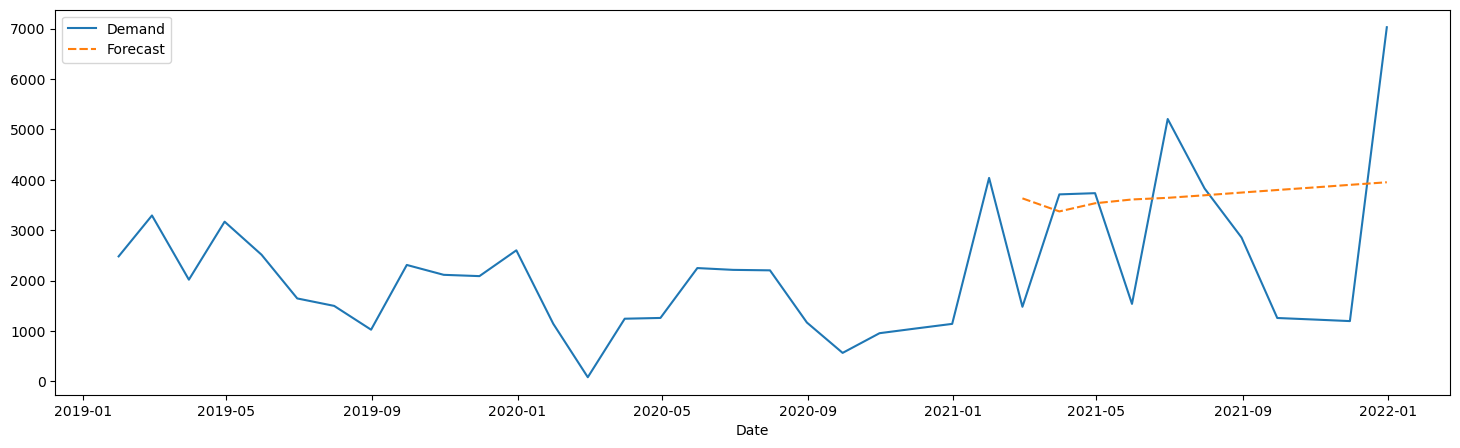

In [63]:
arimaModel = ARIMA((2,1,0),(1,0,0,52)).fit(Train)
Forecast = pd.Series(arimaModel.predict(11)).rename('Forecast')
Forecast.index = Test.index # Needed for the pd.concat to work correctly in the next line
Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)

## Validation
Validation_Df = Actual_Forecast_Df[-11:].copy()
## Plot
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Df)
print("MAPE",np.mean(abs(Validation_Df['Demand'] - Validation_Df['Forecast'])/Validation_Df['Demand'])*100) # MAPE

MAPE 94.93509499319977


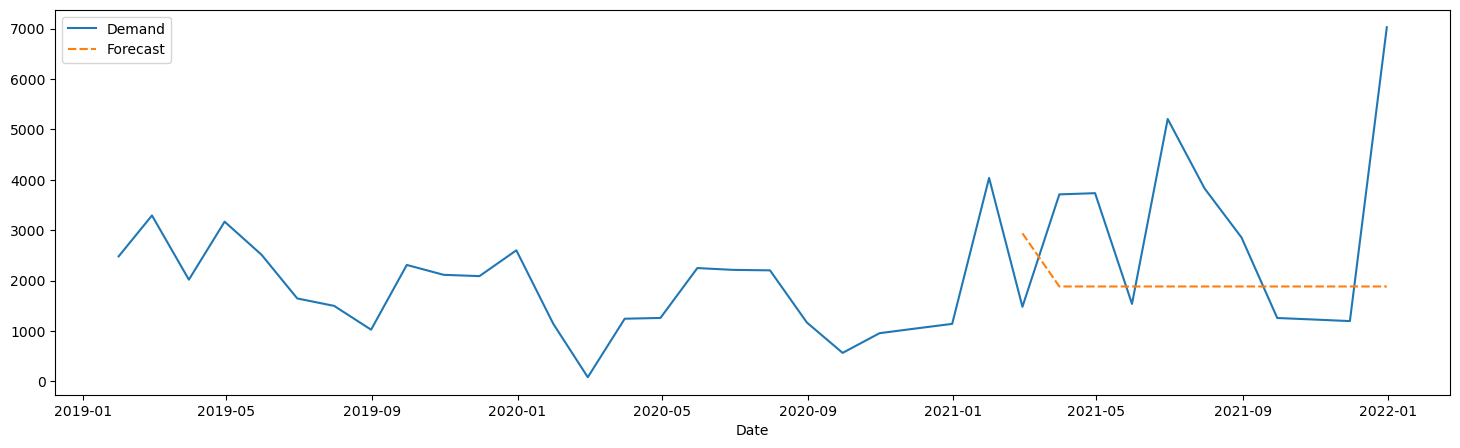

In [64]:
arimaModel2 = auto_arima(Train)
Validation_Df = Actual_Forecast_Df[-11:].copy()
Forecast = pd.Series(arimaModel2.predict(11)).rename('Forecast')
Forecast.index = Test.index
Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1)

## Plot
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Df)
print("MAPE",np.mean(abs(Validation_Df['Demand'] - Validation_Df['Forecast'])/Validation_Df['Demand'])*100) # MAPE

## Stationarity check

In [65]:
def test_stationarity(data):
    
    # Determining rolling statistics
    movingAvg = data.rolling(window=5).mean()
    movingStd = data.rolling(window=5).std()
    
    # Plotting
    plt.figure(figsize=(18,5))
    orig = plt.plot(data,color='blue',label='original')
    mean = plt.plot(movingAvg,color='red',label='Rolling Mean')
    std = plt.plot(movingStd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean and Standard deviation")
    plt.show()
    
    # ADF Test
    dftest = adfuller(data,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','#lags used','Number of observation used'])
    print(dfoutput)
    if dfoutput[1] > 0.05:
        print('\nData is non-stationary')
    else:
        print('\nData is stationary')

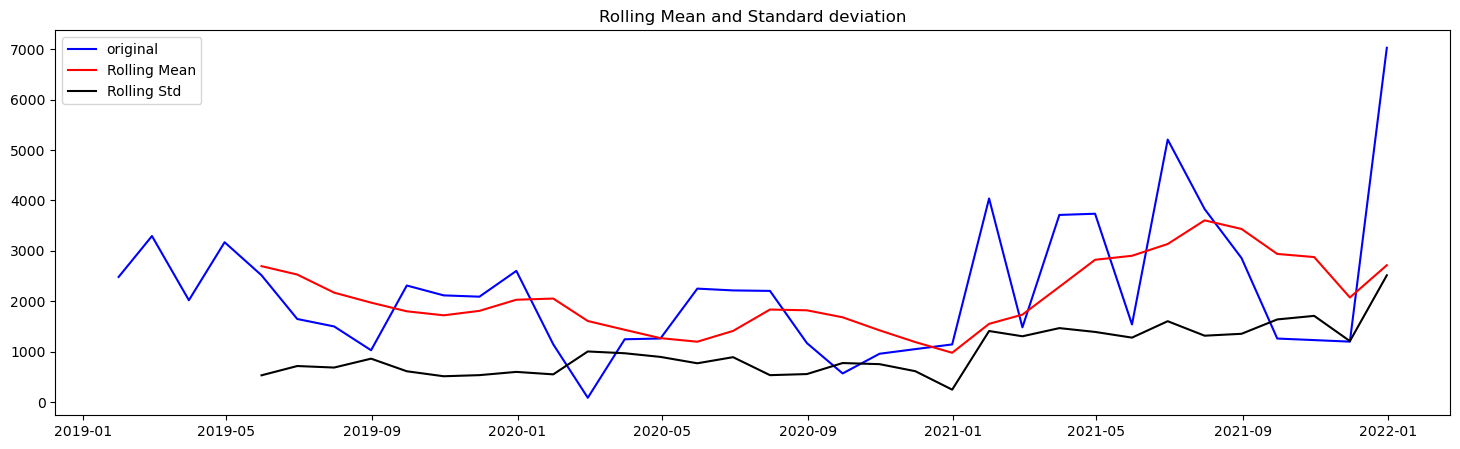

Test Statistics               -3.652437
p-value                        0.004834
#lags used                     0.000000
Number of observation used    35.000000
dtype: float64

Data is stationary


In [66]:
test_stationarity(df1)

In [ ]:
df1

### Forecasting with finalized model

In [67]:
Final_TES2 = ExponentialSmoothing(Train,seasonal='add',trend='add').fit(smoothing_level=0.45,smoothing_slope=0.05,smoothing_seasonal=0.3)

In [68]:
## Forecasting
Forecast = pd.Series(Final_TES2.predict(0)).rename('Forecast')
#Forecast.head()

In [69]:
# Set the correct dates as index of the forecast obtained in the previous line
start = "2021-12-31" 
end = "2023-12-31"
futureDateRange = pd.date_range(start, end, freq='M')

In [70]:
Forecast.index =  futureDateRange 

In [71]:
Actual_Forecast_Df = pd.concat([df1, Forecast], axis = 1) # Column wise binding

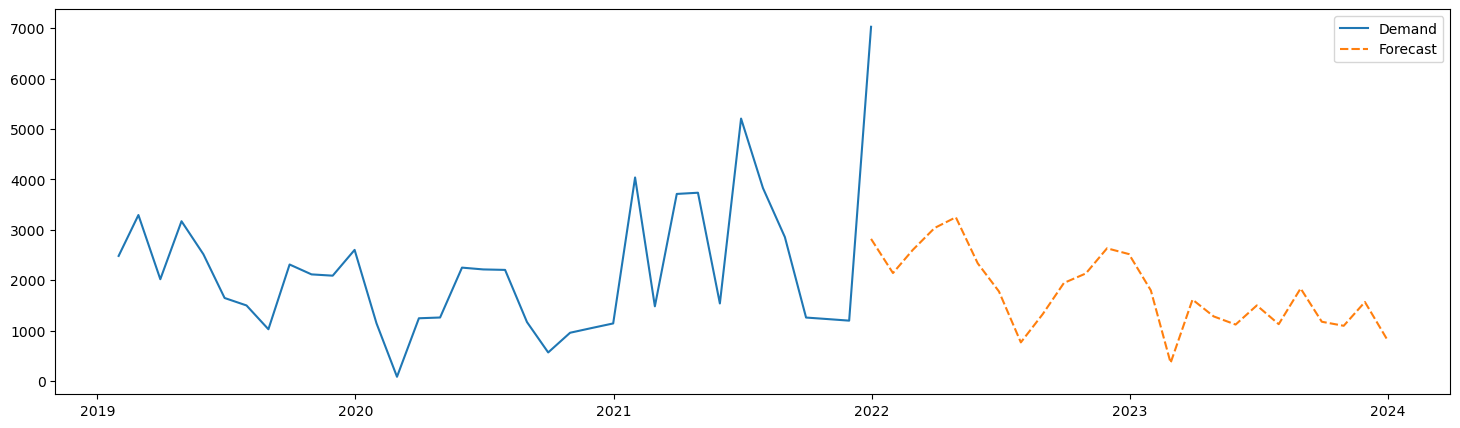

In [72]:
## Plot
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Df)
plt.show()

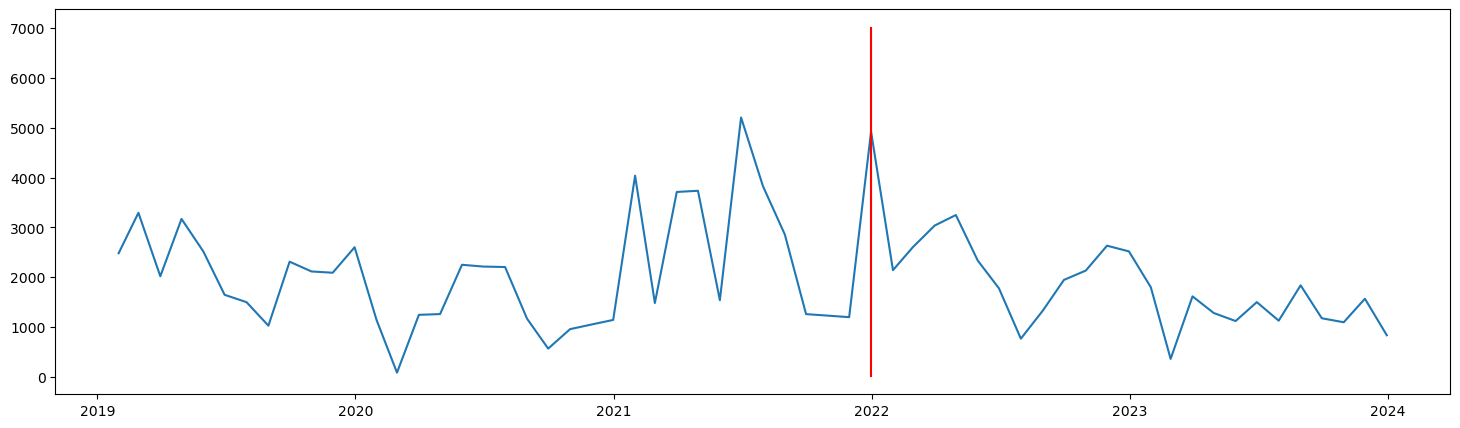

In [73]:
Actual_Forecast_Series = pd.concat([df1, Forecast], axis = 0) # Row wise binding
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Series)
vlines(x = Actual_Forecast_Series.index[36],ymin=0,ymax = max(Actual_Forecast_Series), colors = "red")
plt.show()